# MultiresPolar

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## Load Images and fixation points

In [8]:
# This is for 100 images
#lImages = pickle.load(open("listImages.pkl","rb"))
#ldp = pickle.load(open('ldp.pkl', 'rb'))
#fixations = pickle.load(open("PredIndList.pkl","rb"))

In [11]:
# A smaller sample of 5 images
lImages = pickle.load(open("images5.pkl","rb"))
ldp = pickle.load(open('ldp5.pkl', 'rb'))
fixations = pickle.load(open("PredIndList5.pkl","rb"))

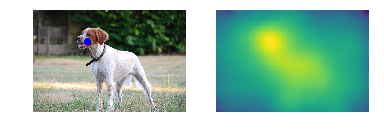

In [24]:
idx = 2
plt.subplot(1,2,1); plt.imshow(lImages[idx]); plt.axis('off');
plt.plot(fixations[idx][1], fixations[idx][0], 'bo')
plt.subplot(1,2,2); plt.imshow(ldp[idx][0,:,:,0]); plt.axis('off');

In [556]:
#plt.imsave('guitar.jpg', lImages[idx])

In [25]:
print(fixations[idx])
print(np.shape(lImages[idx]))

(100, 176)
(334, 500, 3)


In [26]:
diam = 100
ctr = fixations[idx]
img = lImages[idx][ctr[0]-diam:ctr[0]+diam,ctr[1]-diam:ctr[1]+diam]

(200, 200, 3)


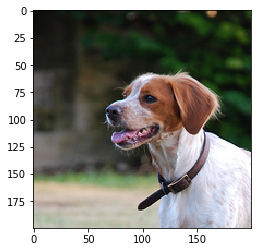

In [27]:
print(np.shape(img))
plt.imshow(img);

## Set up multires pyramid

In [28]:
from skimage.filters import gaussian
from numpy.fft import fft2, ifft2, fftshift, ifftshift

In [29]:
# Blur kernel radii (FWHM)
sigmas = [1., 2, 3, 4, 7, 10., 15]
sigmas = [1., 1.5, 2, 2.5, 3, 3.5, 4, 5, 7, 10., 15]

In [30]:
def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    g = np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    return g/np.sum(g.flatten())

In [31]:
def Depricated_AutoCrop(img, relthresh=0.1):
    N = np.shape(img)[0]
    maximums = np.max(abs(img), axis=1) / np.max(abs(img))
    idx_low = list(maximums>0.1).index(True)
    if idx_low==0:
        return img
    else:
        idx_high = N - 1 - list(reversed(maximums>0.1)).index(True)
    return img[idx_low:idx_high,idx_low:idx_high]

In [37]:
def MyNormalize(img):
    img_min = np.min(img)
    img_max = np.max(img)
    return (img-img_min)/(img_max-img_min)

In [38]:
def AutoCropFilter(N, fwhm=2., relthresh=0.1):
    '''
    G = AutoCropFilter(N, fwhm=2., relthresh=0.1)
    
    Create and crop a Gaussian filter. The image is returned
    in the frequency domain (i.e. the Fourier transform of
    the image). The image is evenly cropped so that the minimum
    of the function is less than the maximum times relthresh.
    
    Inputs:
      N          an integer for the maximum image size
      fwhm       standard deviation of the Gaussian function,
                 expressed as full-width-at-half-max
      relthresh  the threshold for the min/max of the function
      
    Output:
      G  the FFT of the Gaussian function, cropped to a square
         image
    '''
    g = makeGaussian(N, fwhm=fwhm)
    G = fftshift(fft2(ifftshift(g)))
    N = np.shape(G)[0]
    maximums = np.max(abs(G), axis=1) / np.max(abs(G))
    idx_low = list(maximums>0.1).index(True)
    if idx_low==0:
        return G
    else:
        idx_high = N - 1 - list(reversed(maximums>0.1)).index(True)
    return G[idx_low:idx_high,idx_low:idx_high]

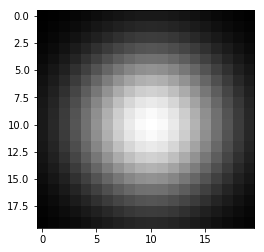

In [39]:
G = AutoCropFilter(255, fwhm=20, relthresh=0.05)
plt.imshow(abs(G), cmap='gray');

In [40]:
def MakeImagePyramid(img, sigmas):
    '''
    pyramid = MakeImagePyramid(img, sigmas)
    
    Construct a list of blurred and subsampled versions of an image.
    
    Inputs:
      img      square image
      sigmas   list of standard deviations for the Gaussian blur kernels
    
    Output:
      pyramid  list of images, varying in size
    '''
    f_pyramid = []
    F = fftshift(fft2(img, axes=[0,1]), axes=[0,1])
    N = np.shape(img)[0]
    chans = np.shape(img)[2]
    for s in sigmas:
        G = AutoCropFilter(N, fwhm=s, relthresh=0.05)
        sd = int( (np.shape(F)[0] - np.shape(G)[0])/2 )
        if sd<=0:
            sd = 0
            Fc = F.copy()
        else:
            Fc = F[sd:-(sd),sd:-(sd),:].copy()
        for c in range(chans):
            Fc[:,:,c] *= G
        Nnew = np.shape(G)[0]
        f_pyramid.append(np.real(ifft2(ifftshift(Fc, axes=[0,1]), axes=[0,1]))/N/N*Nnew**2)
    return f_pyramid

In [41]:
pyr = MakeImagePyramid(img, sigmas)

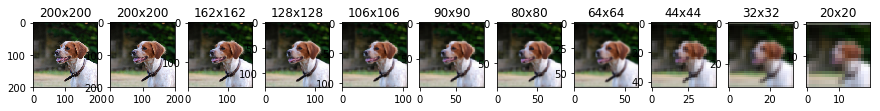

In [42]:
plt.figure(figsize=[15,8])
blur_levels = len(sigmas)
for idx, f in enumerate(pyr):
    plt.subplot(1,blur_levels,idx+1)
    plt.imshow(MyNormalize(f));
    plt.title(str(np.shape(f)[0])+'x'+str(np.shape(f)[1]))

## Polar Transform

In [43]:
def Polar2Cart(ctr, rt):
    x = ctr[0] + rt[0]*np.cos(rt[1])
    y = ctr[1] + rt[0]*np.sin(rt[1])
    return (x,y)

In [44]:
from scipy.ndimage import map_coordinates
def PolarResample(img, r_samples, n_theta=180, ctr=None):
    '''
    p_img = PolarResample(img, r_samples, ctr=None)
    
    Polar resampling of an image.
    
    Inputs:
      img       image array
      r_samples is a list or array of radii at which to sample
      n_theta   number of angles
      ctr       coordinates of the centre of the polar resampling
                If ctr=None, then it chooses the centre pixel
                ctr = floor(dim/2)
    
    Output:
      p_img     an n_radius x n_theta image in polar coordinates
    '''
    if ctr==None:
        ctr = np.array(np.array(np.shape(img)[0:2])/2, dtype=int)
    
    #n_radius = int( (outer_radius - inner_radius)/img_scale + 1)
    n_radius = len(r_samples)
    #n_theta = 180
    #r = np.linspace(inner_radius, outer_radius, n_radius)
    theta = np.linspace(0., 2*np.pi, n_theta, endpoint=False)

    rt = [np.tile(r_samples, (n_theta, 1)).T, np.tile(theta, (n_radius,1))]
    
    xy = np.array(Polar2Cart(ctr, rt))
    xy0 = np.dstack([xy[0], xy[0], xy[0]])
    xy1 = np.dstack([xy[1], xy[1], xy[1]])
    xy2 = np.dstack([np.zeros([n_radius,n_theta,1]),
                     np.ones([n_radius,n_theta,1]),
                     2.*np.ones([n_radius,n_theta,1])])
    xy0 = xy0[np.newaxis,:,:,:]
    xy1 = xy1[np.newaxis,:,:,:]
    xy2 = xy2[np.newaxis,:,:,:]
    xxxyyy = np.concatenate((xy0,xy1,xy2), axis=0)
    
    p_img = map_coordinates(img, xxxyyy, mode='reflect')
    return p_img, xy

In [45]:
[np.shape(pyr[n]) for n in range(len(sigmas))]

[(200, 200, 3),
 (200, 200, 3),
 (162, 162, 3),
 (128, 128, 3),
 (106, 106, 3),
 (90, 90, 3),
 (80, 80, 3),
 (64, 64, 3),
 (44, 44, 3),
 (32, 32, 3),
 (20, 20, 3)]

In [46]:
k = 3
k0 = float(np.shape(pyr[0])[0])
kk = float(np.shape(pyr[k])[0])
s = kk / k0
print(k0, kk, s)
blahk = PolarResample(pyr[k], np.linspace(0, 100*s, 101))

200.0 128.0 0.64


In [47]:
s = np.array([float(np.shape(p)[0]) for p in pyr])
s = s / s[0]
print(s)

[1.   1.   0.81 0.64 0.53 0.45 0.4  0.32 0.22 0.16 0.1 ]


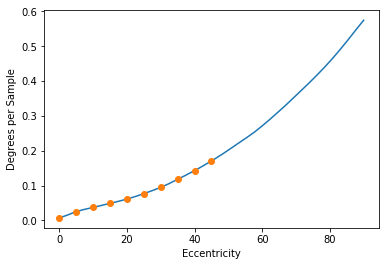

In [48]:
rgc_spacing = np.load('rgc_spacing.npy')
plt.plot(rgc_spacing[0], rgc_spacing[1]);
myx = np.linspace(0, 45, 10)
def f(x):
    return np.interp(x, rgc_spacing[0], rgc_spacing[1])
plt.plot(myx, f(myx), 'o');
plt.xlabel('Eccentricity');
plt.ylabel('Degrees per Sample');

In [49]:
# Get a list of sample locations (eccentricities) that follow the spacing.
samp_next = 0.
samp = [samp_next]
scale = 5. # degrees per pixel
for k in range(100):
    samp_next += f(samp_next)*scale
    samp.append(samp_next)

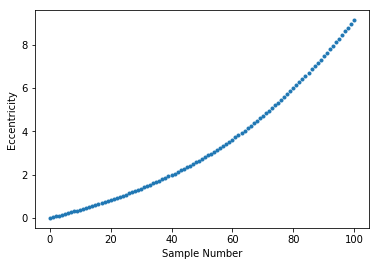

In [50]:
plt.plot(samp, '.')
plt.xlabel('Sample Number')
plt.ylabel('Eccentricity');

In [51]:
annuli = [(20, 25), (40, 25), (50, 25), (60,25), (70, 25), (80, 25), (100, 25)]

In [52]:
annuli = [(10,10), (20,10), (30,10), (40,10), (50,10),
          (60,10), (70,10), (80,10), (90,10), (100,10), (110,10)]

In [53]:
p_img = np.array([[]]) #PolarResample(pyr[0], np.linspace(0, annuli[0][0], annuli[0][1]))
old_r = 0.
xxyy = []
for k in range(len(s)):
    ss = s[k]
    r = annuli[k][0]
    n = annuli[k][1]
    pp = pyr[k]
    if k==0:
        p_img, xy = PolarResample(pp, np.linspace(old_r, r, n, endpoint=False)*ss)
    else:
        blah, xy = PolarResample(pp, np.linspace(old_r, r, n, endpoint=False)*ss)
        p_img = np.concatenate((p_img, blah), axis=0)
    xxyy.append(xy/ss)
    old_r = r

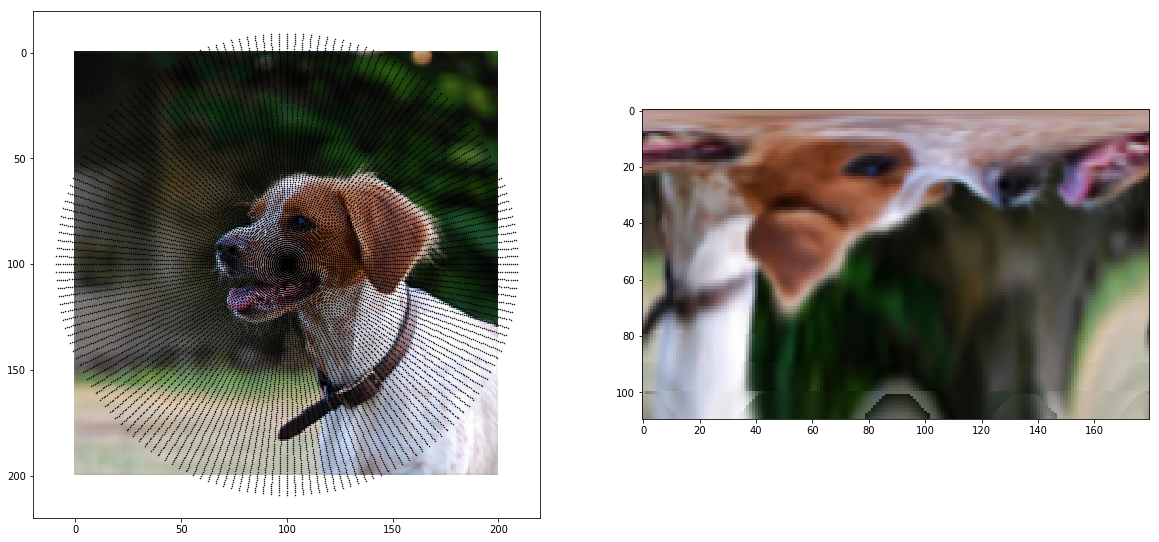

In [54]:
plt.figure(figsize=[20,10])
plt.subplot(1,2,2); plt.imshow(MyNormalize(p_img));
plt.subplot(1,2,1); plt.imshow(MyNormalize(pyr[0]));
for xy in xxyy:
    plt.plot(xy[0], xy[1], 'k.', markersize=1.);